In [17]:
import numpy as np
import pandas as pd
import imputation as imp
import forecasting as fc
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from codecarbon import EmissionsTracker
from eco2ai import Tracker

In [18]:
df = pd.read_csv("datasets/maxwell/household_data_60min.csv", index_col="utc_timestamp")
df = df.drop(columns=["cet_cest_timestamp"])
df = df.select_dtypes(include="number")
df.head()

,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,DE_KN_industrial3_area_room_1,DE_KN_industrial3_area_room_2,...,DE_KN_residential5_grid_import,DE_KN_residential5_refrigerator,DE_KN_residential5_washing_machine,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-11T17:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-11T18:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-11T19:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-11T20:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-11T21:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
prefixes = [
    "DE_KN_industrial1",
    "DE_KN_industrial2",
    "DE_KN_industrial3",
    "DE_KN_public1",
    "DE_KN_public2",
    "DE_KN_residential1",
    "DE_KN_residential2",
    "DE_KN_residential3",
    "DE_KN_residential4",
    "DE_KN_residential5",
    "DE_KN_residential6",
]

In [ ]:
imputation_methods = {
    "LOCF": imp.locf,
    "NOCB": imp.nocb,
    "Linear Interpolation": imp.linear_interpolation,
    "Linear Regression": imp.linear_regression,
    "K-Nearest Neighbor": imp.knn,
    "MICE": imp.mice,
    "LightGBM": imp.lightgbm,
}


imputed = {}

for prefix in prefixes:
    cols = [col for col in df.columns if col.startswith(prefix)]
    target = prefix + "_grid_import"
    df_building = df[cols]
    df_masked, samples = imp.create_mcar_data(df_building, missing=0.2, seed=42)

    for n, f in imputation_methods.items():
        cc_tracker = EmissionsTracker(
            project_name=n,
            output_dir="performance/results",
            output_file="maxwell_codecarbon.csv",
        )
        eco_tracker = Tracker(project_name=n, file_name="performance/results/maxwell_eco2ai.csv")

        # Start time and emission trackers
        cc_tracker.start()
        eco_tracker.start()

        try:
            df_imputed = f(df_masked.copy())
        except Exception as e:
            df_imputed = df_masked.copy()
            df_imputed.loc[:, target] = np.nan

        # Stop trackers
        emissions = cc_tracker.stop()
        eco_tracker.stop()

        # Store imputed data in dictionary
        imputed[(prefix, n)] = {
            "data": df_imputed,
            "target": target,
            "original": df_building,
            "samples": samples,
        }

        # Get error metrics only for the masked values
        i = df_building.columns.get_loc(target)
        mask = samples[:, i]
        y_true = df_building.values[:, i][mask]
        y_pred = df_imputed.values[:, i][mask]

        valid = (~np.isnan(y_true)) & (~np.isnan(y_pred))
        y_true = y_true[valid]
        y_pred = y_pred[valid]

        # Compute error
        if len(y_true) > 0 and np.max(y_true) != np.min(y_true):
            mae = mean_absolute_error(y_true, y_pred)
            nrmse = root_mean_squared_error(y_true, y_pred) / (np.max(y_true) - np.min(y_true))
        else:
            mae = np.nan
            nrmse = np.nan

        r = pd.DataFrame(
            [
                {
                    "method": n,
                    "building": prefix,
                    "target": target,
                    "dataset": "genome",
                    "MAE": mae,
                    "NRMSE": nrmse,
                }
            ]
        )
        r.to_csv(
            "performance/results/maxwell_performance.csv", mode="a", index=False, header=False
        )

[codecarbon WARNING @ 15:49:33] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:49:33] [setup] RAM Tracking...
[codecarbon INFO @ 15:49:33] [setup] CPU Tracking...
[codecarbon WARNING @ 15:49:35] We saw that you have a AMD Ryzen 5 7530U with Radeon Graphics but we don't know it. Please contact us.
[codecarbon WARNING @ 15:49:35] We will use the default power consumption of 4 W per thread for your 12 CPU, so 48W.
[codecarbon WARNING @ 15:49:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:49:35] CPU Model on constant consumption mode: AMD Ryzen 5 7530U with Radeon Graphics
[codecarbon WARNING @ 15:49:35] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 15:49:35] [setup] GPU Tracking...
[codecarbon INFO @ 15:49:35] No GPU found.
[codecarbon INFO @ 15:49

[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13171, number of used features: 2
[LightGBM] [Info] Start training from score 220724.627930
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13909, number of used features: 2
[LightGBM] [Info] Start training from score 4518.954918
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 13801, number of used features: 2
[LightGBM] [Info] Start training from score 3569.771103


[codecarbon INFO @ 15:51:09] Energy consumed for RAM : 0.000006 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:51:09] Delta energy consumed for CPU with cpu_load : 0.000006 kWh, power : 10.152000000000001 W
[codecarbon INFO @ 15:51:09] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 15:51:09] 0.000012 kWh of electricity used since the beginning.
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_dataframe.loc[row_index] = attributes_array
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1631710529327393' ha

[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 9038, number of used features: 3
[LightGBM] [Info] Start training from score 8017.496513
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 9584, number of used features: 3
[LightGBM] [Info] Start training from score 10705.724966
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 7836, number of used features: 3
[LightGBM] [Info] Start training from score 827.272912


[codecarbon INFO @ 15:52:54] Energy consumed for RAM : 0.000006 kWh. RAM Power : 10.0 W


[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 7878, number of used features: 3
[LightGBM] [Info] Start training from score 503.748226


[codecarbon INFO @ 15:52:55] Delta energy consumed for CPU with cpu_load : 0.000006 kWh, power : 9.336 W
[codecarbon INFO @ 15:52:55] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 15:52:55] 0.000012 kWh of electricity used since the beginning.
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_dataframe.loc[row_index] = attributes_array
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2289745807647705' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_d

[LightGBM] [Info] Total Bins 4784
[LightGBM] [Info] Number of data points in the train set: 11492, number of used features: 19
[LightGBM] [Info] Start training from score 8477.415396
[LightGBM] [Info] Total Bins 4781
[LightGBM] [Info] Number of data points in the train set: 11431, number of used features: 19
[LightGBM] [Info] Start training from score 3146.253786
[LightGBM] [Info] Total Bins 4780
[LightGBM] [Info] Number of data points in the train set: 11524, number of used features: 19
[LightGBM] [Info] Start training from score 14615.391272
[LightGBM] [Info] Total Bins 4780
[LightGBM] [Info] Number of data points in the train set: 11515, number of used features: 19
[LightGBM] [Info] Start training from score 2894.874319
[LightGBM] [Info] Total Bins 4781
[LightGBM] [Info] Number of data points in the train set: 11569, number of used features: 19
[LightGBM] [Info] Start training from score 20277.173244
[LightGBM] [Info] Total Bins 4774
[LightGBM] [Info] Number of data points in the tr

[codecarbon INFO @ 15:55:52] Energy consumed for RAM : 0.007247 kWh. RAM Power : 10.0 W


[LightGBM] [Info] Total Bins 4780
[LightGBM] [Info] Number of data points in the train set: 11402, number of used features: 19
[LightGBM] [Info] Start training from score 96859.602233


[codecarbon INFO @ 15:55:52] Energy consumed for RAM : 0.000015 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:55:52] Delta energy consumed for CPU with cpu_load : 0.000089 kWh, power : 22.071 W
[codecarbon INFO @ 15:55:52] Energy consumed for All CPU : 0.009624 kWh
[codecarbon INFO @ 15:55:52] 0.016871 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:55:52] Delta energy consumed for CPU with cpu_load : 0.000031 kWh, power : 20.296 W
[codecarbon INFO @ 15:55:52] Energy consumed for All CPU : 0.000031 kWh
[codecarbon INFO @ 15:55:52] 0.000047 kWh of electricity used since the beginning.
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_dataframe.loc[row_index] = attributes_array
/home/

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 3650, number of used features: 0


[codecarbon INFO @ 15:57:17] Delta energy consumed for CPU with cpu_load : 0.000002 kWh, power : 4.896000000000001 W
[codecarbon INFO @ 15:57:17] Energy consumed for All CPU : 0.000002 kWh
[codecarbon INFO @ 15:57:17] 0.000007 kWh of electricity used since the beginning.
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_dataframe.loc[row_index] = attributes_array
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8339431285858154' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 910, number of used features: 0


[codecarbon INFO @ 15:58:46] Delta energy consumed for CPU with cpu_load : 0.000002 kWh, power : 4.896000000000001 W
[codecarbon INFO @ 15:58:46] Energy consumed for All CPU : 0.000002 kWh
[codecarbon INFO @ 15:58:46] 0.000007 kWh of electricity used since the beginning.
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_dataframe.loc[row_index] = attributes_array
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8288919925689697' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  

[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12754, number of used features: 5
[LightGBM] [Info] Start training from score 143.546201
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 10327, number of used features: 5
[LightGBM] [Info] Start training from score 215.454576
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 12597, number of used features: 5
[LightGBM] [Info] Start training from score 4464.555601
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 12677, number of used features: 5
[LightGBM] [Info] Start training from score 4029.227769
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 12741, number of used features: 5
[LightGBM] [Info] Start training from score 9281.819588
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 

[codecarbon INFO @ 16:00:38] Energy consumed for RAM : 0.000007 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:00:38] Delta energy consumed for CPU with cpu_load : 0.000007 kWh, power : 10.104000000000003 W
[codecarbon INFO @ 16:00:38] Energy consumed for All CPU : 0.000007 kWh
[codecarbon INFO @ 16:00:38] 0.000014 kWh of electricity used since the beginning.
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_dataframe.loc[row_index] = attributes_array
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.4893689155578613' ha

[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 15909, number of used features: 4
[LightGBM] [Info] Start training from score 409.124259
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 15346, number of used features: 4
[LightGBM] [Info] Start training from score 256.719906
[LightGBM] [Info] Total Bins 1019
[LightGBM] [Info] Number of data points in the train set: 8217, number of used features: 4
[LightGBM] [Info] Start training from score 70.729503
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 12694, number of used features: 4
[LightGBM] [Info] Start training from score 2026.525205


[codecarbon INFO @ 16:02:31] Energy consumed for RAM : 0.000007 kWh. RAM Power : 10.0 W


[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 19805, number of used features: 4
[LightGBM] [Info] Start training from score 192.504806


[codecarbon INFO @ 16:02:32] Delta energy consumed for CPU with cpu_load : 0.000006 kWh, power : 9.696 W
[codecarbon INFO @ 16:02:32] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 16:02:32] 0.000013 kWh of electricity used since the beginning.
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_dataframe.loc[row_index] = attributes_array
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3996121883392334' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_d

[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 26449, number of used features: 7
[LightGBM] [Info] Start training from score 949.969683
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 23345, number of used features: 7
[LightGBM] [Info] Start training from score 712.782041
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 23057, number of used features: 7
[LightGBM] [Info] Start training from score 268.027393
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 17969, number of used features: 7
[LightGBM] [Info] Start training from score 4381.469616
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 9470, number of used features: 7
[LightGBM] [Info] Start training from score 2514.642499
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 18

[codecarbon INFO @ 16:04:48] Energy consumed for RAM : 0.000009 kWh. RAM Power : 10.0 W


[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 24555, number of used features: 7
[LightGBM] [Info] Start training from score 997.879183


[codecarbon INFO @ 16:04:48] Delta energy consumed for CPU with cpu_load : 0.000015 kWh, power : 17.632 W
[codecarbon INFO @ 16:04:48] Energy consumed for All CPU : 0.000015 kWh
[codecarbon INFO @ 16:04:48] 0.000024 kWh of electricity used since the beginning.
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_dataframe.loc[row_index] = attributes_array
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.149843692779541' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_d

[LightGBM] [Info] Total Bins 2029
[LightGBM] [Info] Number of data points in the train set: 10014, number of used features: 8
[LightGBM] [Info] Start training from score 71.103031
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 16250, number of used features: 8
[LightGBM] [Info] Start training from score 1168.741159
[LightGBM] [Info] Total Bins 2024
[LightGBM] [Info] Number of data points in the train set: 16283, number of used features: 8
[LightGBM] [Info] Start training from score 184.256364
[LightGBM] [Info] Total Bins 2024
[LightGBM] [Info] Number of data points in the train set: 16320, number of used features: 8
[LightGBM] [Info] Start training from score 9140.139193
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 16333, number of used features: 8
[LightGBM] [Info] Start training from score 4994.745245
[LightGBM] [Info] Total Bins 2023
[LightGBM] [Info] Number of data points in the train set: 9

[codecarbon INFO @ 16:06:58] Energy consumed for RAM : 0.011875 kWh. RAM Power : 10.0 W


[LightGBM] [Info] Total Bins 2024
[LightGBM] [Info] Number of data points in the train set: 16340, number of used features: 8
[LightGBM] [Info] Start training from score 11758.521362
[LightGBM] [Info] Total Bins 2034
[LightGBM] [Info] Number of data points in the train set: 8548, number of used features: 8
[LightGBM] [Info] Start training from score 92.444766


[codecarbon INFO @ 16:06:59] Energy consumed for RAM : 0.000008 kWh. RAM Power : 10.0 W


[LightGBM] [Info] Total Bins 2031
[LightGBM] [Info] Number of data points in the train set: 9901, number of used features: 8
[LightGBM] [Info] Start training from score 77.626186


[codecarbon INFO @ 16:06:59] Delta energy consumed for CPU with cpu_load : 0.000042 kWh, power : 10.317 W
[codecarbon INFO @ 16:06:59] Energy consumed for All CPU : 0.015381 kWh
[codecarbon INFO @ 16:06:59] 0.027256 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:06:59] Energy consumed for RAM : 0.007489 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:06:59] Energy consumed for RAM : 0.011513 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:06:59] Delta energy consumed for CPU with cpu_load : 0.000013 kWh, power : 15.168000000000001 W
[codecarbon INFO @ 16:06:59] Energy consumed for All CPU : 0.000013 kWh
[codecarbon INFO @ 16:06:59] 0.000021 kWh of electricity used since the beginning.
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicit

[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 18746, number of used features: 3
[LightGBM] [Info] Start training from score 316.068751
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 24731, number of used features: 3
[LightGBM] [Info] Start training from score 4694.249298
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 11686, number of used features: 3
[LightGBM] [Info] Start training from score 294.241217
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 18844, number of used features: 3
[LightGBM] [Info] Start training from score 244.450620


[codecarbon INFO @ 16:08:47] Energy consumed for RAM : 0.000006 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:08:48] Delta energy consumed for CPU with cpu_load : 0.000006 kWh, power : 9.72 W
[codecarbon INFO @ 16:08:48] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 16:08:48] 0.000012 kWh of electricity used since the beginning.
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_dataframe.loc[row_index] = attributes_array
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3120903968811035' has dtype incomp

[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 17180, number of used features: 6
[LightGBM] [Info] Start training from score 456.587851
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 11308, number of used features: 6
[LightGBM] [Info] Start training from score 45.736667
[LightGBM] [Info] Total Bins 1524
[LightGBM] [Info] Number of data points in the train set: 12250, number of used features: 6
[LightGBM] [Info] Start training from score 100.689054
[LightGBM] [Info] Total Bins 1512
[LightGBM] [Info] Number of data points in the train set: 13315, number of used features: 6
[LightGBM] [Info] Start training from score 2178.736279
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 17246, number of used features: 6
[LightGBM] [Info] Start training from score 4215.027487
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 17

[codecarbon INFO @ 16:10:49] Energy consumed for RAM : 0.000007 kWh. RAM Power : 10.0 W


[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 11858, number of used features: 6
[LightGBM] [Info] Start training from score 38.401406


[codecarbon INFO @ 16:10:50] Delta energy consumed for CPU with cpu_load : 0.000006 kWh, power : 8.816 W
[codecarbon INFO @ 16:10:50] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 16:10:50] 0.000013 kWh of electricity used since the beginning.
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_dataframe.loc[row_index] = attributes_array
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.636678695678711' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_da

[codecarbon INFO @ 16:10:52] Energy consumed for RAM : 0.009662 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:10:52] Delta energy consumed for CPU with cpu_load : 0.000043 kWh, power : 10.644 W
[codecarbon INFO @ 16:10:52] Energy consumed for All CPU : 0.013179 kWh
[codecarbon INFO @ 16:10:52] 0.022841 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:10:52] 0.001848 g.CO2eq/s mean an estimation of 58.281755392339974 kg.CO2eq/year
[codecarbon INFO @ 16:10:58] Energy consumed for RAM : 0.012520 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:10:59] Delta energy consumed for CPU with cpu_load : 0.000043 kWh, power : 10.623000000000001 W
[codecarbon INFO @ 16:10:59] Energy consumed for All CPU : 0.016352 kWh
[codecarbon INFO @ 16:10:59] 0.028872 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:10:59] Energy consumed for RAM : 0.008132 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:10:59] Energy consumed for RAM : 0.012157 kWh. RAM Power : 10.0 W
[codecarbon

In [ ]:
forecasting = {}

for i, ((building, name), d) in enumerate(imputed.items()):
    df_imputed = d["data"]
    features = [col for col in df_imputed.columns if col != target]

    X = df_imputed[features]
    y = df_imputed[d["target"]]

    X_train, X_test, y_train, y_test = fc.split_data(X, y, train_size=0.8)

    model = LGBMRegressor(force_col_wise=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        valid = (~np.isnan(y_test)) & (~np.isnan(y_pred))
        mae = mean_absolute_error(y_test[valid], y_pred[valid])

        forecasting[(building, name)] = {
            "building": building,
            "method": name,
            "target": target,
            "MAE": mae,
            "dataset": "genome",
        }
    except:
        forecasting[(building, name)] = {
            "building": building,
            "method": name,
            "target": target,
            "MAE": np.nan,
            "dataset": "genome",
        }

df_forecasting = pd.DataFrame.from_dict(forecasting, orient="index").reset_index()
df_forecasting.rename(columns={"level_0": "building", "level_1": "method"}, inplace=True)
df_forecasting.to_csv("performance/results/maxwell_forecasting.csv", index=False)

[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 3
[LightGBM] [Info] Start training from score 216270.154650
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 3
[LightGBM] [Info] Start training from score 118369.435484
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 3
[LightGBM] [Info] Start training from score 216274.569772
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 3
[LightGBM] [Info] Start training from score 212032.014837
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 3
[LightGBM] [Info] Start training from score 215308.722698
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train

[codecarbon INFO @ 16:20:29] Energy consumed for RAM : 0.014049 kWh. RAM Power : 10.0 W


[LightGBM] [Info] Total Bins 5011
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 20
[LightGBM] [Info] Start training from score 440252.185887
[LightGBM] [Info] Total Bins 5036
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 20
[LightGBM] [Info] Start training from score 171864.038491


[codecarbon INFO @ 16:20:29] Delta energy consumed for CPU with cpu_load : 0.000042 kWh, power : 10.317 W
[codecarbon INFO @ 16:20:29] Energy consumed for All CPU : 0.017438 kWh
[codecarbon INFO @ 16:20:29] 0.031487 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:20:29] Energy consumed for RAM : 0.013687 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:20:29] Energy consumed for RAM : 0.009662 kWh. RAM Power : 10.0 W


[LightGBM] [Info] Total Bins 5013
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 20
[LightGBM] [Info] Start training from score 440284.088240
[LightGBM] [Info] Total Bins 5098
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 20
[LightGBM] [Info] Start training from score 350775.254941
[LightGBM] [Info] Total Bins 5003
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 20
[LightGBM] [Info] Start training from score 421109.057426


[codecarbon INFO @ 16:20:30] Delta energy consumed for CPU with cpu_load : 0.000046 kWh, power : 11.523 W
[codecarbon INFO @ 16:20:30] Energy consumed for All CPU : 0.017164 kWh
[codecarbon INFO @ 16:20:30] 0.030851 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:20:30] Delta energy consumed for CPU with cpu_load : 0.000046 kWh, power : 11.526 W
[codecarbon INFO @ 16:20:30] Energy consumed for All CPU : 0.012423 kWh
[codecarbon INFO @ 16:20:30] 0.022085 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:20:30] 0.001190 g.CO2eq/s mean an estimation of 37.53199684315345 kg.CO2eq/year


[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 20
[LightGBM] [Info] Start training from score 348366.429332
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 20
[LightGBM] [Info] Start training from score 573589.288268
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 1
[LightGBM] [Info] Start training from score 6240.515883
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 1
[LightGBM] [Info] Start training from score 770.248460
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 30763, number of used features: 1
[LightGBM] [Info] Start training from score 6241.061520
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configu

[codecarbon INFO @ 16:20:37] Energy consumed for RAM : 0.011232 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:20:37] Delta energy consumed for CPU with cpu_load : 0.000068 kWh, power : 16.959 W
[codecarbon INFO @ 16:20:37] Energy consumed for All CPU : 0.014334 kWh
[codecarbon INFO @ 16:20:37] 0.025566 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:20:44] Energy consumed for RAM : 0.014090 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:20:44] Delta energy consumed for CPU with cpu_load : 0.000056 kWh, power : 13.938 W
[codecarbon INFO @ 16:20:44] Energy consumed for All CPU : 0.017494 kWh
[codecarbon INFO @ 16:20:44] 0.031583 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:20:44] Energy consumed for RAM : 0.013727 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:20:44] Energy consumed for RAM : 0.009703 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:20:45] Delta energy consumed for CPU with cpu_load : 0.000052 kWh, power : 12.975000000000001 W
[codecar

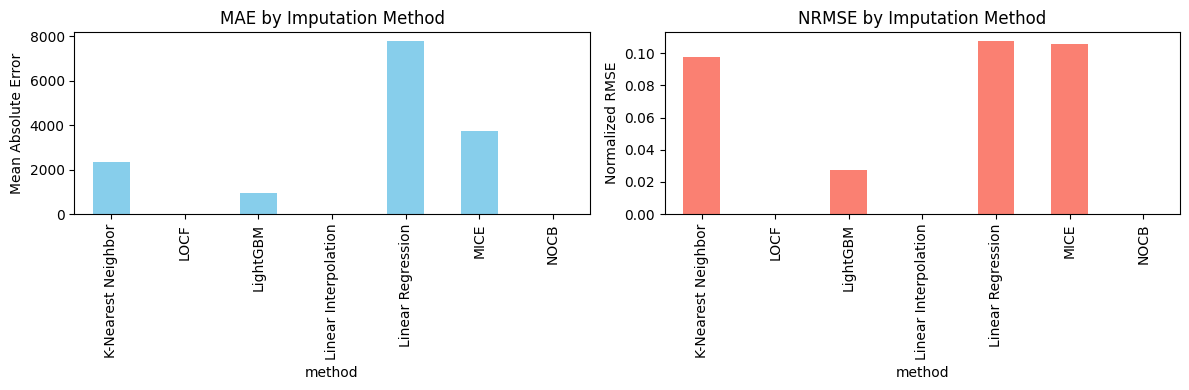

[codecarbon INFO @ 16:22:29] Energy consumed for RAM : 0.014372 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:22:29] Delta energy consumed for CPU with cpu_load : 0.000028 kWh, power : 6.8580000000000005 W
[codecarbon INFO @ 16:22:29] Energy consumed for All CPU : 0.017675 kWh
[codecarbon INFO @ 16:22:29] 0.032047 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:22:29] Energy consumed for RAM : 0.014009 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:22:29] Energy consumed for RAM : 0.009984 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:22:30] Delta energy consumed for CPU with cpu_load : 0.000028 kWh, power : 6.954000000000001 W
[codecarbon INFO @ 16:22:30] Energy consumed for All CPU : 0.017395 kWh
[codecarbon INFO @ 16:22:30] 0.031404 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:22:30] Delta energy consumed for CPU with cpu_load : 0.000028 kWh, power : 6.945 W
[codecarbon INFO @ 16:22:30] Energy consumed for All CPU : 0.012655 kWh
[codecarbon IN

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

df_performance = pd.read_csv("performance/results/maxwell_performance.csv")
df_performance["MAE"] = pd.to_numeric(df_performance["MAE"], errors="coerce")
df_performance["NRMSE"] = pd.to_numeric(df_performance["NRMSE"], errors="coerce")
df_plot = df_performance.groupby("method")[["MAE", "NRMSE"]].mean()

df_plot["MAE"].plot(kind="bar", ax=axs[0], color="skyblue")
axs[0].set_title("MAE by Imputation Method")
axs[0].set_ylabel("Mean Absolute Error")
axs[0].set_xticklabels(df_plot.index, rotation=90)

df_plot["NRMSE"].plot(kind="bar", ax=axs[1], color="salmon")
axs[1].set_title("NRMSE by Imputation Method")
axs[1].set_ylabel("Normalized RMSE")
axs[1].set_xticklabels(df_plot.index, rotation=90)

plt.tight_layout()
plt.savefig(f"performance/figures/maxwell/imputation.png")
plt.show()

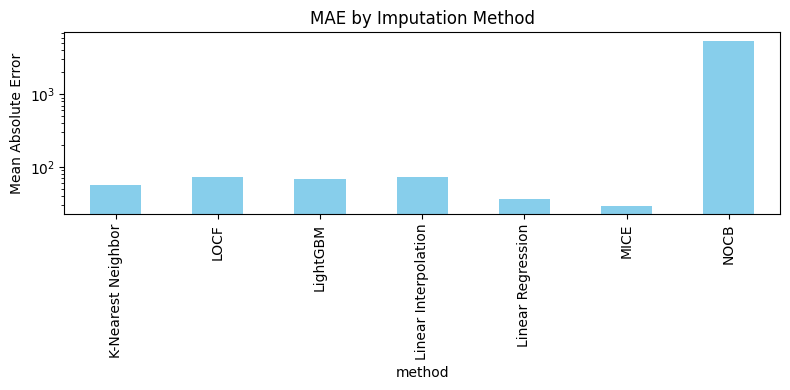

[codecarbon INFO @ 16:23:22] Energy consumed for RAM : 0.011675 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:23:22] Delta energy consumed for CPU with cpu_load : 0.000026 kWh, power : 6.465000000000001 W
[codecarbon INFO @ 16:23:22] Energy consumed for All CPU : 0.014623 kWh
[codecarbon INFO @ 16:23:22] 0.026298 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:23:29] Energy consumed for RAM : 0.014532 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:23:29] Delta energy consumed for CPU with cpu_load : 0.000029 kWh, power : 7.275 W
[codecarbon INFO @ 16:23:29] Energy consumed for All CPU : 0.017785 kWh
[codecarbon INFO @ 16:23:29] 0.032318 kWh of electricity used since the beginning.


In [40]:
df_performance = pd.read_csv("performance/results/maxwell_forecasting.csv")
df_performance["MAE"] = pd.to_numeric(df_performance["MAE"], errors="coerce")
df_plot = df_performance.groupby("method")[["MAE"]].mean()

fig, ax = plt.subplots(figsize=(8, 4))

df_plot["MAE"].plot(kind="bar", ax=ax, color="skyblue")
plt.title("MAE by Imputation Method")
plt.ylabel("Mean Absolute Error")
plt.yscale("log")
plt.tick_params(axis="x", rotation=90)

plt.tight_layout()
plt.savefig(f"performance/figures/maxwell/forecasting.png")

[codecarbon INFO @ 16:23:52] Delta energy consumed for CPU with cpu_load : 0.000029 kWh, power : 7.146000000000002 W
[codecarbon INFO @ 16:23:52] Energy consumed for All CPU : 0.014686 kWh
[codecarbon INFO @ 16:23:52] 0.026442 kWh of electricity used since the beginning.


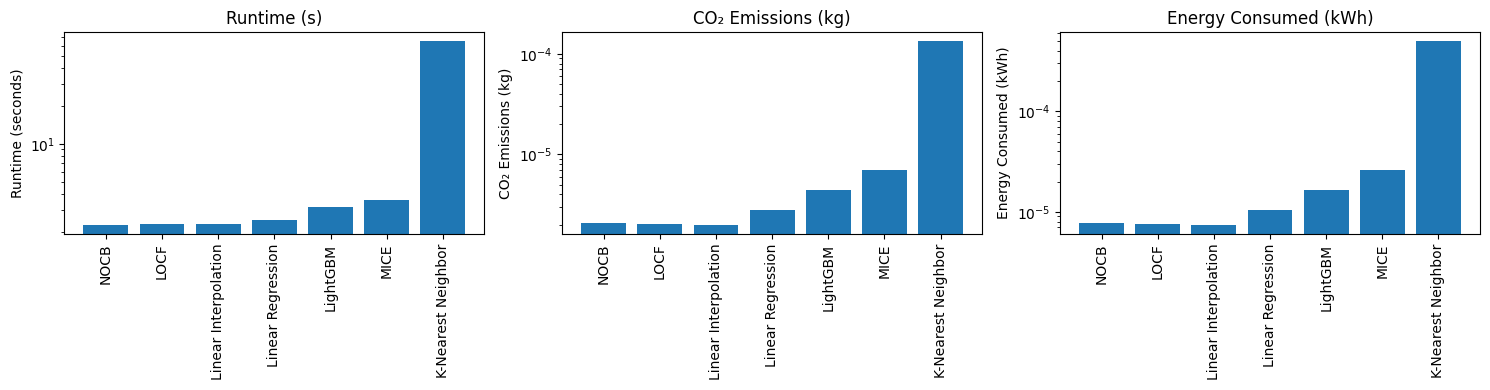

[codecarbon INFO @ 16:23:59] Energy consumed for RAM : 0.014613 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:23:59] Delta energy consumed for CPU with cpu_load : 0.000031 kWh, power : 7.698000000000001 W
[codecarbon INFO @ 16:23:59] Energy consumed for All CPU : 0.017848 kWh
[codecarbon INFO @ 16:23:59] 0.032461 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:23:59] Energy consumed for RAM : 0.014251 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:23:59] Energy consumed for RAM : 0.010226 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:24:00] Delta energy consumed for CPU with cpu_load : 0.000031 kWh, power : 7.815 W
[codecarbon INFO @ 16:24:00] Energy consumed for All CPU : 0.017572 kWh
[codecarbon INFO @ 16:24:00] 0.031823 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:00] Delta energy consumed for CPU with cpu_load : 0.000033 kWh, power : 8.145 W
[codecarbon INFO @ 16:24:00] Energy consumed for All CPU : 0.012833 kWh
[codecarbon INFO @ 16:24:00

In [ ]:
df_emission = pd.read_csv(f"performance/results/maxwell_codecarbon.csv")
df_plot = (
    df_emission.groupby("project_name")[["duration", "emissions", "energy_consumed"]]
    .mean()
    .sort_values("duration")
)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].bar(df_plot.index, df_plot["duration"])
axs[0].set_title("Runtime (s)")
axs[0].set_yscale("log")
axs[0].set_ylabel("Runtime (seconds)")
axs[0].tick_params(axis="x", rotation=90)

axs[1].bar(df_plot.index, df_plot["emissions"])
axs[1].set_title("CO₂ Emissions (kg)")
axs[1].set_yscale("log")
axs[1].set_ylabel("CO₂ Emissions (kg)")
axs[1].tick_params(axis="x", rotation=90)

axs[2].bar(df_plot.index, df_plot["energy_consumed"])
axs[2].set_title("Energy Consumed (kWh)")
axs[2].set_yscale("log")
axs[2].set_ylabel("Energy Consumed (kWh)")
axs[2].tick_params(axis="x", rotation=90)


plt.tight_layout()
plt.savefig("performance/figures/maxwell/emissions_codecarbon.png")
plt.show()

[codecarbon INFO @ 16:24:22] Delta energy consumed for CPU with cpu_load : 0.000035 kWh, power : 8.577 W
[codecarbon INFO @ 16:24:22] Energy consumed for All CPU : 0.014751 kWh
[codecarbon INFO @ 16:24:22] 0.026587 kWh of electricity used since the beginning.


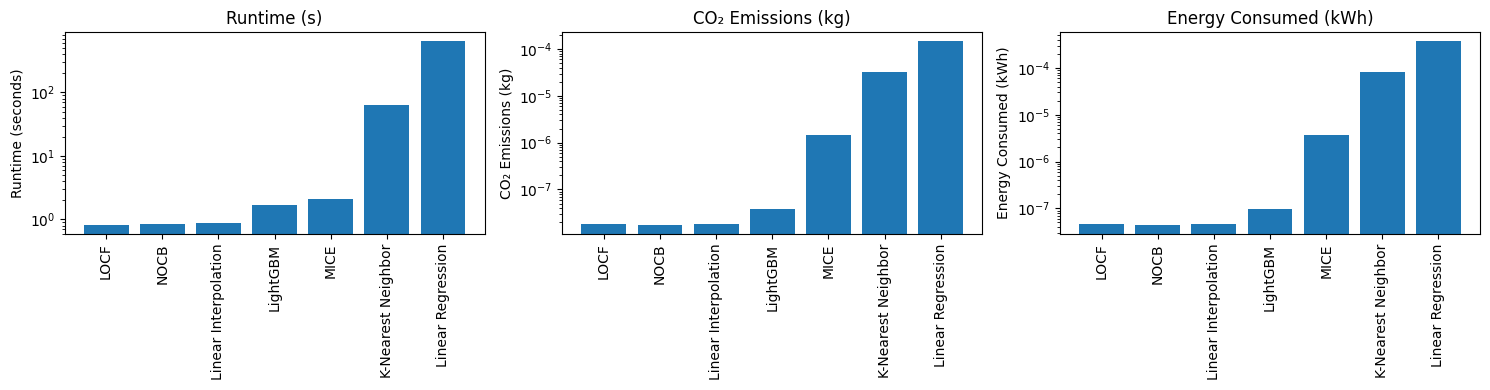

[codecarbon INFO @ 16:24:29] Energy consumed for RAM : 0.014694 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:24:29] Delta energy consumed for CPU with cpu_load : 0.000033 kWh, power : 8.232 W
[codecarbon INFO @ 16:24:29] Energy consumed for All CPU : 0.017908 kWh
[codecarbon INFO @ 16:24:29] 0.032602 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:29] Energy consumed for RAM : 0.014331 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:24:29] Energy consumed for RAM : 0.010306 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:24:30] Delta energy consumed for CPU with cpu_load : 0.000035 kWh, power : 8.718 W
[codecarbon INFO @ 16:24:30] Energy consumed for All CPU : 0.017636 kWh
[codecarbon INFO @ 16:24:30] 0.031967 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:30] Delta energy consumed for CPU with cpu_load : 0.000036 kWh, power : 8.844000000000001 W
[codecarbon INFO @ 16:24:30] Energy consumed for All CPU : 0.012898 kWh
[codecarbon INFO @ 16:24:30

In [ ]:
# Plot eco2ai performance
df_emission = pd.read_csv("performance/results/maxwell_eco2ai.csv")
df_plot = (
    df_emission.groupby("project_name")[["duration(s)", "CO2_emissions(kg)", "power_consumption(kWh)"]]
    .mean()
    .sort_values("duration(s)")
)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].bar(df_plot.index, df_plot["duration(s)"])
axs[0].set_title("Runtime (s)")
axs[0].set_yscale("log")
axs[0].set_ylabel("Runtime (seconds)")
axs[0].tick_params(axis="x", rotation=90)

axs[1].bar(df_plot.index, df_plot["CO2_emissions(kg)"])
axs[1].set_title("CO₂ Emissions (kg)")
axs[1].set_yscale("log")
axs[1].set_ylabel("CO₂ Emissions (kg)")
axs[1].tick_params(axis="x", rotation=90)

axs[2].bar(df_plot.index, df_plot["power_consumption(kWh)"])
axs[2].set_title("Energy Consumed (kWh)")
axs[2].set_yscale("log")
axs[2].set_ylabel("Energy Consumed (kWh)")
axs[2].tick_params(axis="x", rotation=90)


plt.tight_layout()
plt.savefig(f"performance/figures/maxwell/emissions_eco2ai.png")
plt.show()